In [1]:
import os
import sys
import pdb
import re
import argparse
import subprocess
import string
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Data Prepration

In [2]:
def remove_emoticons(text):
    emoji_pattern = re.compile(
        u'([\U0001F1E6-\U0001F1FF]{2})|' # flags
        u'([\U0001F600-\U0001F64F])'     # emoticons
        "+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

def dataset_split(text):
    train, test = train_test_split(text, test_size=0.2, random_state=14)
    return train, test

def data_preparation(text, out_dir, test_size:float=0.2):
    """ pre-process text corpus, split into train-test and save"""
    # Remove all punctuations except "? , !"
    remove = string.punctuation
    remove = remove.replace("?", "").replace(",", "").replace("!", "")
    pattern = r"[{}]".format(remove) # create the pattern
    text = re.sub(pattern, "", text) 
    # text = text.translate(str.maketrans('', '', string.punctuation))

    all_lines = text.split('\n')
    # Strip emoticons, english strings, whitespaces
    prepro_text = []
    for line in all_lines:
        if line:
            line = remove_emoticons(line) # remove flag symbols
            line = re.sub("[A-Za-z]+","",line) # remove english chars
            line = re.sub(r"\s+", " ", line) # remove white spaces
            line = re.sub(r'(\W)(?=\1)', '', line) # remove repeated occurrences of punctuation to single occurrence.
            line = line.replace("?", "?\n").replace(",", ",\n").replace("!", "!\n").replace("।", "।\n")
            lines = line.split("\n")
            for line in lines:
                prepro_text.append(line.strip())
            
    with open(out_dir + '/original_dataset.txt', 'w') as fpw:
        fpw.write('\n'.join(prepro_text))

    train, test = dataset_split(prepro_text)
    with open(out_dir + '/bn_train.txt', 'w') as train_fpw, open(out_dir + '/bn_test.txt', 'w') as test_fpw:
        train_fpw.write('\n'.join(train))
        test_fpw.write('\n'.join(test))

## Creating data for LM

In [3]:
def model_train(vocab_size, prefix, out_dir, spm_model_dir):
    splits = ["train", "test"]
    for split in splits:
        input = str(out_dir + '/bn_' + split + '.txt')
        pref = str(spm_model_dir + '/' + prefix + '_' + split)
        
        # Step 1: train the model and specify the target vocabulary size
        cmd_step1 = "spm_train \
                    --input=" +  input + " \
                    --model_prefix=" + pref + " \
                    --vocab_size=" + str(vocab_size) + "     \
                    --character_coverage=0.995 \
                    --model_type=bpe"
        
        # Step 2: segment the text using this model.
        spm_model = pref + '.model'
        output = str(out_dir + '/'+ prefix + '_' + split + '.txt')
        cmd_step2 = "spm_encode \
                    --model=" + spm_model + " \
                    --output_format=piece \
                    < " + input + " \
                    > " + output
        os.system(cmd_step1)
        os.system(cmd_step2)

## LM training

In [4]:
def lm_train(prefix, class_size, out_dir, rnn_model_dir, hid=40,bptt=3):
    # train language model based on the different subword 
    # granularity: char, subword unit(small vocab), subword unit(large vocab)
    os.makedirs(rnn_model_dir, exist_ok=True)
    print("*"*20 + " Begin LM training: " + "*"*20)
    train = str(out_dir + '/'+ prefix + '_' + "train" + '.txt')
    valid = str(out_dir + '/'+ prefix + '_' + "test" + '.txt')
    hid = str(hid)
    bptt = str(bptt)
    # pdb.set_trace()
    ext = prefix + '_hid_' + hid + "_bptt_" + bptt + "_class_" + class_size
    rnn_model = str(rnn_model_dir+'/rnnlm_'+ext)
    
    cmd = "rnnlm/rnnlm \
            -train " + train + " \
            -valid " + valid + " \
            -rnnlm " + rnn_model + " \
            -hidden " + hid + " \
            -rand-seed 1 \
            -debug 2 \
            -bptt " + bptt + " \
            -class " + class_size
    os.system(cmd)
    print("Model saved: " + rnn_model)
    print("*"*20 + " LM training DONE " + "*"*20)

## Text generation

In [5]:
def text_generation(prefix, class_size, out_dir, spm_model_dir, rnn_model_dir, hid=40,bptt=3):
    # go from subword unit segmentation back to the original text 
    
    hid = str(hid)
    bptt = str(bptt)
    ext = prefix + '_hid_' + hid + "_bptt_" + bptt + "_class_" + class_size
    rnn_model =  str(rnn_model_dir+'/rnnlm_'+ext)
    spm_model = str(spm_model_dir + '/' + prefix + '_train.model')
    
    for k in range(1, 8):
        os.makedirs('gen_text_bn/'+ ext, exist_ok=True)
        cmd = "rnnlm/rnnlm \
            -rnnlm " + rnn_model + " \
            -gen " + str(10**k) + " \
            -debug 0 \
            >> " + str('gen_text_bn/' + ext + '/k_' + str(k) + '.txt')
            
        cmd_decode = "spm_decode \
            --model=" + spm_model + " \
            --input_format=piece \
            < " + str('gen_text_bn/' + ext + '/k_' + str(k) + '.txt') + " \
            > " + str('gen_text_bn/' + ext + '/k_' + str(k) + '_decoded.txt')
        
        os.system(cmd)
        os.system(cmd_decode)
    
    print("*"*20 + " Text generation completed " + "*"*20)

## OOV comparison

In [12]:
def vocab_generator(data):
    remove = string.punctuation
    pattern = r"[{}]".format(remove) # create the pattern
    text = re.sub(pattern, "", data) 
    vocabs = text.split()
    return list(vocabs)

def oov_calculator(train, test):
    mathces = np.in1d(test,train)
    # pdb.set_trace()
    unseen_tokens = len(mathces) - np.count_nonzero(mathces)
    # unseen_tokens = [tok for tok in test if tok not in train]
    oov_rate = unseen_tokens/len(test)
#     print("len of unseen tokens:",unseen_tokens,"test set length:", len(test),'\n')
    return oov_rate

def oov_comparison(prefix, class_size, out_dir, hid=40,bptt=3):
    print("*"*10," OOV comparison ","*"*10)
    hid = str(hid)
    bptt = str(bptt)
    ext = prefix + '_hid_' + hid + "_bptt_" + bptt + "_class_" + class_size
    train_vocabs = vocab_generator(Path(out_dir + "/bn_train.txt").open('r').read())
    test_vocabs = vocab_generator(Path(out_dir + "/bn_test.txt").open('r').read())
    rnn_vocabs = defaultdict()
    oov_rates = []
    for path in Path('gen_text_bn/'+ext).rglob('*decoded.txt'):
        print(path)
        k = path.name.split(".")[0]
        rnn_vocabs[k] = vocab_generator(Path(path).open('r').read())
        # 5.2
        print("Computing OOV rate: k =", k.split("_")[1], end = "\r")
        oov_rates.append(oov_calculator(train_vocabs+rnn_vocabs[k], test_vocabs))
    
    # all_rnn_vocabs = list(set([word for item in list(rnn_vocabs.values()) for word in item]))
    # 5.1
    print("Generating OOV on given corpus")
    oov_corpus = oov_calculator(train_vocabs, test_vocabs)
    print("OOV rate on given corpus: %.3f" %(oov_corpus))
    oov2 = "OOV rate for each K"
    print(oov2+'\n')
    with open(str('gen_text_bn/'+ext+'/') + '/oov.txt', 'w') as fpw:
        fpw.write('OOV rate on given corpus:'+str(oov_corpus)+'\n')
        fpw.write(oov2)
        for k, ovr in enumerate(oov_rates):
            fpw.write(str(k+1)+':'+'\t'+str(ovr)+  '\n')
            print(str(k+1)+':'+'\t'+str(ovr))
    
    # 5.3
    # if error, install 
    # sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
    xticklabels = []
    xaxis = []
    for i in range(1,8):
        xaxis.append(10**i)
        xticklabels.append(('$10^{'  +str(i) + '}$'))
    fig, ax = plt.subplots()
    plt.plot(xticklabels, oov_rates)
    ax.set_xlabel(r'\textbf{K}')
    ax.set_ylabel(r'\textbf{OOV rate}')
    ax.set_title(r'\textbf{OOV: Bengali corpus}')
    plt.savefig(str('gen_text_bn/'+ext+'/') + '/bengali_oov.pdf', bbox_inches='tight')
    plt.show()

## Calling all functions

In [8]:
out_dir = "out_dir_bn"
spm_model_dir = "spm_model"
rnn_model_dir = "rnn_model"
corpus_fp = "data/bengali_corpus.txt"

os.makedirs(out_dir, exist_ok=True)
os.makedirs(spm_model_dir, exist_ok=True)
data_preparation(Path(corpus_fp).open('r').read(), out_dir)

### 1. Baseline: for 3 levels of granularity
    1. LM Model training
    2. Text Generation
    3. OOV comparison and plotting

**********  OOV comparison  **********
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_1_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_2_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_3_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_4_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_5_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_6_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_40_bptt_3_class_52/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15683853523592203
4:	0.15661972711501493
5:	0.1550568119656784
6:	0.1488989262772924
7:	0.13528593532657113


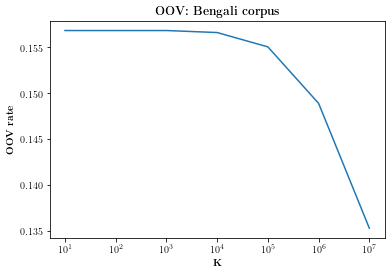

**********  OOV comparison  **********
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_1_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_2_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_3_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_4_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_5_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_6_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_40_bptt_3_class_400/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15677601862994858
4:	0.15651032305456136
5:	0.15394714220964945
6:	0.1432880608911742
7:	0.12481440382601629


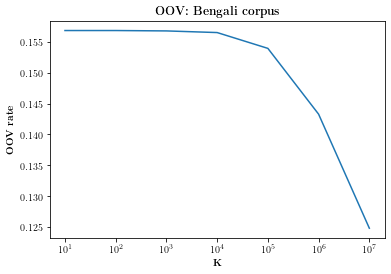

**********  OOV comparison  **********
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_1_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_2_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_3_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_4_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_5_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_6_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15682290608442867
3:	0.15677601862994858
4:	0.15638528984261443
5:	0.15304065142303425
6:	0.13902130253348546
7:	0.11432724317396808


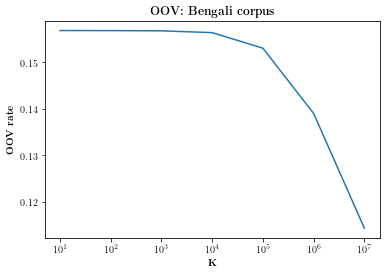

In [13]:
hid=40
bptt=3
vocab_sizes = [52, 400, 3000]
# vocab_sizes = [201]
# class size is kept same as vocab size
for prefix, vocab_size in enumerate(vocab_sizes):
    class_size = str(vocab_size)
    prefix = "bn_s" + str(prefix+1) + "_vocab_size_" + str(vocab_size)
    model_train(vocab_size, prefix, out_dir, spm_model_dir)
    lm_train(prefix, class_size, out_dir, rnn_model_dir, hid,bptt)
    text_generation(prefix, class_size, out_dir, spm_model_dir, rnn_model_dir, hid,bptt)
    oov_comparison(prefix, class_size, out_dir, hid, bptt)

#### Baseline perplexities

In [18]:
!tail -3 rnn_model/rnnlm_bn_s1_vocab_size_52_hid_40_bptt_3_class_52.output.txt

iter: 3
valid log probability: -378749.124294
PPL net: 10.026335


In [19]:
!tail -3 rnn_model/rnnlm_bn_s2_vocab_size_400_hid_40_bptt_3_class_400.output.txt

iter: 8
valid log probability: -302844.264352
PPL net: 62.794973


In [20]:
!tail -3 rnn_model/rnnlm_bn_s3_vocab_size_3000_hid_40_bptt_3_class_3000.output.txt

iter: 10
valid log probability: -260422.883086
PPL net: 376.060040


### 2. Hyper-parameter tuning I: for 3 levels of granularity
    1. LM Model training
    2. Text Generation
    3. OOV comparison and plotting

Set hidden layer=90, bptt=4

**********  OOV comparison  **********
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_1_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_2_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_3_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_4_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_5_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_6_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_90_bptt_4_class_52/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15674476032696186
4:	0.15660409796352157
5:	0.15507244111717175
6:	0.14816435615710424
7:	0.1314099057562165


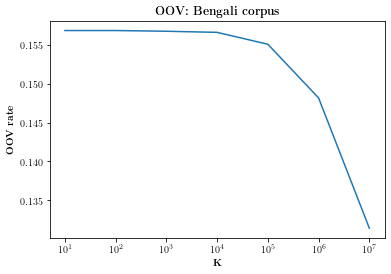

**********  OOV comparison  **********
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_1_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_2_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_3_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_4_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_5_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_6_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_90_bptt_4_class_400/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15682290608442867
4:	0.156494693903068
5:	0.15366581748276886
6:	0.14270978228591968
7:	0.12100089086163512


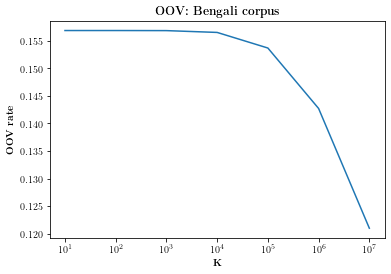

**********  OOV comparison  **********
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_1_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_2_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_3_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_4_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_5_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_6_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15683853523592203
4:	0.15630714408514762
5:	0.1528843599081006
6:	0.13792726192894988
7:	0.11237359923729741


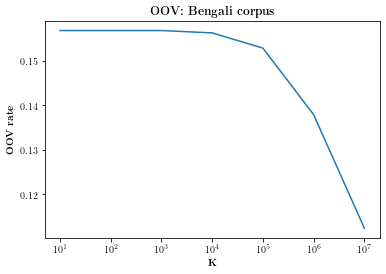

In [14]:
hid=90
bptt=4
vocab_sizes = [52, 400, 3000]
# vocab_sizes = [201]
# class size is kept same as vocab size
for prefix, vocab_size in enumerate(vocab_sizes):
    class_size = str(vocab_size)
    prefix = "bn_s" + str(prefix+1) + "_vocab_size_" + str(vocab_size)
    model_train(vocab_size, prefix, out_dir, spm_model_dir)
    lm_train(prefix, class_size, out_dir, rnn_model_dir, hid,bptt)
    text_generation(prefix, class_size, out_dir, spm_model_dir, rnn_model_dir, hid,bptt)
    oov_comparison(prefix, class_size, out_dir, hid, bptt)

#### Hyper-parameter tuning I: perplexities

In [21]:
!tail -3 rnn_model/rnnlm_bn_s1_vocab_size_52_hid_90_bptt_4_class_52.output.txt

iter: 5
valid log probability: -343786.851127
PPL net: 8.104513


In [29]:
!tail -3 rnn_model/rnnlm_bn_s2_vocab_size_400_hid_90_bptt_4_class_400.output.txt

iter: 10
valid log probability: -288352.547215
PPL net: 51.509875


In [30]:
!tail -3 rnn_model/rnnlm_bn_s3_vocab_size_3000_hid_90_bptt_4_class_3000.output.txt

iter: 10
valid log probability: -259358.858372
PPL net: 367.058522


### 3. Hyper-parameter tuning II: for 3 levels of granularity
    1. LM Model training
    2. Text Generation
    3. OOV comparison and plotting

Set hidden layer=120, bptt=3

**********  OOV comparison  **********
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_1_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_2_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_3_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_4_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_5_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_6_decoded.txt
gen_text_bn/bn_s1_vocab_size_52_hid_120_bptt_4_class_52/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15683853523592203
4:	0.15660409796352157
5:	0.15504118281418502
6:	0.14753919009736963
7:	0.12970632824343967


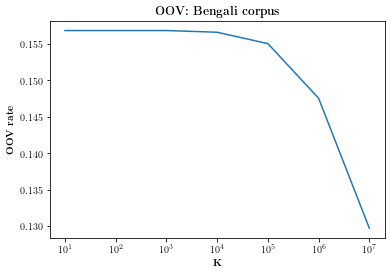

**********  OOV comparison  **********
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_1_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_2_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_3_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_4_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_5_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_6_decoded.txt
gen_text_bn/bn_s2_vocab_size_400_hid_120_bptt_4_class_400/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15683853523592203
4:	0.15638528984261443
5:	0.15390025475516933
6:	0.1424440867105325
7:	0.12026632074144694


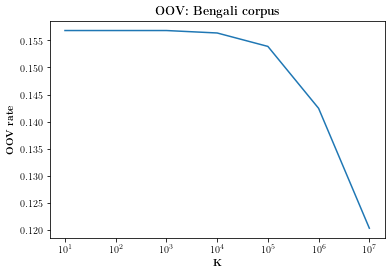

**********  OOV comparison  **********
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_1_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_2_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_3_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_4_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_5_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_6_decoded.txt
gen_text_bn/bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000/k_7_decoded.txt
Generating OOV on given corpus
OOV rate on given corpus: 0.157
OOV rate for each K

1:	0.15683853523592203
2:	0.15683853523592203
3:	0.15683853523592203
4:	0.15643217729709455
5:	0.15308753887751433
6:	0.13817732835284371
7:	0.11338949408436616


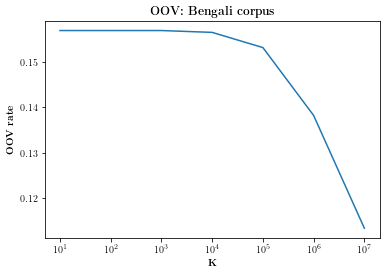

In [15]:
hid=120
bptt=4
vocab_sizes = [52, 400, 3000]
# class size is kept same as vocab size
for prefix, vocab_size in enumerate(vocab_sizes):
    class_size = str(vocab_size)
    prefix = "bn_s" + str(prefix+1) + "_vocab_size_" + str(vocab_size)
    model_train(vocab_size, prefix, out_dir, spm_model_dir)
    lm_train(prefix, class_size, out_dir, rnn_model_dir, hid,bptt)
    text_generation(prefix, class_size, out_dir, spm_model_dir, rnn_model_dir, hid,bptt)
    oov_comparison(prefix, class_size, out_dir, hid, bptt)

#### Hyper-parameter tuning II: perplexities

In [26]:
!tail -3 rnn_model/rnnlm_bn_s1_vocab_size_52_hid_120_bptt_4_class_52.output.txt

iter: 8
valid log probability: -326863.548095
PPL net: 7.311287


In [32]:
!tail -3 rnn_model/rnnlm_bn_s2_vocab_size_400_hid_120_bptt_4_class_400.output.txt

iter: 11
valid log probability: -284909.382886
PPL net: 49.141582


In [31]:
!tail -3 rnn_model/rnnlm_bn_s3_vocab_size_3000_hid_120_bptt_4_class_3000.output.txt

iter: 11
valid log probability: -259191.813757
PPL net: 365.665047
